# Data Science Salary Prediction: Logistic Regression With Grid-Search

In [104]:
# importing:
import pandas as pd
import sklearn.feature_selection
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve


In [105]:
datasets = "datasets/"
df = pd.read_csv(datasets + "Kaggle_Salary.csv", low_memory=False)
df.head()


,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,...,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,NaN,NaN
1,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3.0,"30,000-39,999"
2,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0.0,"0-9,999"
3,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,...,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1,14.0,">250,000"
4,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0.0,"0-9,999"


### Data Visualization

In [106]:
print("Number of rows =", df.shape[0])
print("Number of columns =", df.shape[1])

Number of rows = 12498
Number of columns = 248


## Data Cleaning
### Converting Categorical Data Into Numerical Data
There are a few options for encoding categorical data into numerical data. Given a categorical column we can choose to either encode each element numerically, encode the column using one-hot encoding, or encode the column using a custom one-hot encoding. 

Suppose the dataset in question is a dataset that contains information regarding which car each respondent owns. The column in question is ```car_type```. This column can take on 3 different values: ```tesla```, ```toyota```, and ```bmw```. The following will demonstrate three different types of encoding methods.

#### Numerical Encoding 
To numerically encode the ```car_type``` category we would assign the possible values that ```car_type``` could be as numerical values. We could encode ```tesla``` as 0, ```toyota``` as 1, and ```bmw``` as 2. The problem with this encoding method is the weighting implied by the numerical values. Are BMW's twice as valuable, heavy, or fast as Toyotas? If the data does not relate to the encoding in any way it is better to use one-hot encoding instead.

#### One-Hot Encoding
To encode a column using one-hot encoding we assign each possible value in a particular column its own column. Then, the values in each of these new columns is either 0 or 1 depending on if that particular entry possesses that property. ```tesla```, ```toyota```, and ```bmw``` would all be separate columns with boolean values in each entry. The drawback of one-hot encoding is the number of columns explodes with the number of unique values in each categorical column. In this rather simple example we added an additional 2 columns. If we repeated this process for a large number of categorical columns with many unique values in each column we would end up with a very large dataset that would take a long time to operate on. A potential solution is delinated by the next method.

#### Customized One-Hot Encoding
Suppose that in our example there are a total of 1000 respondents. 975 respondents own Teslas, 15 own BMWs, and 10 own Toyotas. In this case, it might be wiser to refactor our original ```car_type``` column to a more simple binary column like ```owns_tesla```. This would prevent an explosion of columns and would retain the attractive categorical implications of one-hot encoding. One could also situationally create a column called ```other``` that would encompass all of the other entires for a given dataset to refrain from adding several columns containing little information. Critically thinking about which encoding method you should use is essential for generating accurate models. 

### Column Visualization
Each column must be investigated to determine which encoding method should be used for each column.

In [107]:
question_dict = dict()

for i in range(df.shape[1]):
    if len(df.columns[i]) <= 3 or ("Part_1" in df.columns[i] and "Part_10" not in df.columns[i] and "Part_11" not in df.columns[i] and "Part_12" not in df.columns[i] and "Part_13" not in df.columns[i]):
        question_dict[df.columns[i]] =  df.iloc[0, i]

# Determining Which Questions Were Asked:
print("\nQuestions Asked in Dataset:\n")
for (key, value) in question_dict.items():
    print(key)
    print(value, "\n")



Questions Asked in Dataset:

Q1
What is your age (# years)? 

Q2
What is your gender? - Selected Choice 

Q3
In which country do you currently reside? 

Q4
What is the highest level of formal education that you have attained or plan to attain within the next 2 years? 

Q5
Select the title most similar to your current role (or most recent title if retired): - Selected Choice 

Q6
What is the size of the company where you are employed? 

Q7
Approximately how many individuals are responsible for data science workloads at your place of business? 

Q8
Does your current employer incorporate machine learning methods into their business? 

Q9_Part_1
Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions 

Q10
What is your current yearly compensation (approximate $USD)? 

Q11
Approximately how much money have you spent on machine learning and/or cloud computing

In [108]:
# Determining Which Questions Were Multiple Choice Questions:
print("\nMultiple Choice Questions in Dataset")
multiple_choice_dict = dict()
for (key, value) in question_dict.items():
    if "_" in key:
        multiple_choice_dict[key] = value
        print(key)
        print(value, "\n")



Multiple Choice Questions in Dataset
Q9_Part_1
Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions 

Q12_Part_1
Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - Twitter (data science influencers) 

Q13_Part_1
On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Udacity 

Q14_Part_1_TEXT
What is the primary tool that you use at work or school to analyze data? (Include text response) - Basic statistical software (Microsoft Excel, Google Sheets, etc.) - Text 

Q16_Part_1
Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice - Jupyter (JupyterLab, Jupyter Notebooks, etc)  

Q17_Part_1
Which of the following hosted notebook products do you

Multiple choice columns currently are populated by either a non-unique string that answers the particular categorical question or a NaN value. Consider Q9_Part_1, for example: 

In [109]:
print("Total number of rows =", df["Q9_Part_1"].shape[0])
print("Number of rows that are NaN =", df["Q9_Part_1"].shape[0] - df["Q9_Part_1"].dropna().count())
print("Each column value can either take on '{}' or '{}'".format(df["Q9_Part_1"].unique()[1], df["Q9_Part_1"].unique()[2]))

Total number of rows = 12498
Number of rows that are NaN = 6518
Each column value can either take on 'nan' or 'Analyze and understand data to influence product or business decisions'


For each of these columns we will fill the NaN entries (which imply negative responses) with 0's and we will replace all of the string values (which imply affirmative responses) with 1's. This will result columns that are one-hot encoded. 

In [110]:
def replace_strings(value):
    if value is not np.nan:
        return 1
    return 0

for column in df.columns:
    if "Text" in column:
        pass
    elif "Part" in column:
        df.loc[1:, column] = df.loc[1:, column].map(replace_strings)

In [111]:
column_question_dict = dict()
for column in df.columns:
    column_question_dict[column] = df.iloc[0][column]
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,...,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,NaN,NaN
1,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,0,0,0,0,0,0,0,-1,3.0,"30,000-39,999"
2,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,...,0,0,0,0,0,0,0,-1,0.0,"0-9,999"
3,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,...,0,0,0,1,0,0,0,-1,14.0,">250,000"
4,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,...,0,0,0,0,0,0,0,-1,0.0,"0-9,999"


Now that all of the columns that were originally categorical are usable, we will now investigate the one-hot encoded columns to see if any columns have less than 50 respondents that selected that column. Columns that have less than 50 selections will be merged into an "other" column for that particular question.

In [112]:
question_list = []
for column in df.columns:
    if "TEXT" in column:
        pass
    elif "Part" in column:
        print("Count for Question {} = {}".format(column[:2] if column[2] == "_" else column[:3], df[1:][column].sum()))

Count for Question Q9 = 5979
Count for Question Q9 = 3507
Count for Question Q9 = 4890
Count for Question Q9 = 3285
Count for Question Q9 = 3634
Count for Question Q9 = 2303
Count for Question Q9 = 515
Count for Question Q9 = 239
Count for Question Q12 = 2785
Count for Question Q12 = 1386
Count for Question Q12 = 2404
Count for Question Q12 = 7757
Count for Question Q12 = 2817
Count for Question Q12 = 5116
Count for Question Q12 = 1644
Count for Question Q12 = 7333
Count for Question Q12 = 3494
Count for Question Q12 = 1881
Count for Question Q12 = 374
Count for Question Q12 = 883
Count for Question Q13 = 2278
Count for Question Q13 = 6487
Count for Question Q13 = 2439
Count for Question Q13 = 2978
Count for Question Q13 = 557
Count for Question Q13 = 3666
Count for Question Q13 = 1190
Count for Question Q13 = 3561
Count for Question Q13 = 1010
Count for Question Q13 = 3062
Count for Question Q13 = 994
Count for Question Q13 = 1277
Count for Question Q16 = 7815
Count for Question Q16 =

Since each categorical column has more than 50 selections no columns will be combined. Now that we have one-hot encoded the already multiple choice data we will deal with the rest of the columns present in the dataset. 

#### "TEXT" and "OTHER_TEXT" Columns
The "TEXT" and "OTHER_TEXT" columns are columns that encode each respondent's reply with a numerical encoding. Respondent's with a similar reply have the same encoding. We run into the same problem we typically run into when using numerical encoding: higher numerical encoding values aren't indicative of some implicit greater quantity. How will the model interpret a response encoding of 134 versus a response encoding of 4? 

Instead of one-hot encoding all of the unique responses we will instead chooes to ignore the "TEXT" and "OTHER_TEXT" columns. We will do this because the information presented by these columns is mostly captured by the "Other" columns preceeding these text columns.

In [113]:
for column in df.columns:
    if "TEXT" in column or "OTHER_TEXT" in column:
        print(column)
        df.drop([column], axis=1, inplace=True)

Q2_OTHER_TEXT
Q5_OTHER_TEXT
Q9_OTHER_TEXT
Q12_OTHER_TEXT
Q13_OTHER_TEXT
Q14_Part_1_TEXT
Q14_Part_2_TEXT
Q14_Part_3_TEXT
Q14_Part_4_TEXT
Q14_Part_5_TEXT
Q14_OTHER_TEXT
Q16_OTHER_TEXT
Q17_OTHER_TEXT
Q18_OTHER_TEXT
Q19_OTHER_TEXT
Q20_OTHER_TEXT
Q21_OTHER_TEXT
Q24_OTHER_TEXT
Q25_OTHER_TEXT
Q26_OTHER_TEXT
Q27_OTHER_TEXT
Q28_OTHER_TEXT
Q29_OTHER_TEXT
Q30_OTHER_TEXT
Q31_OTHER_TEXT
Q32_OTHER_TEXT
Q33_OTHER_TEXT
Q34_OTHER_TEXT


Now we must deal with the rest of the categorical columns before we begin investigating the impacts of each column. 

#### Age Range Encoding (Q1)
For this column each response is an age range. Therefore, a clear relationship exists between the various ranges. We could capture this relationship by numerically encoding each range. 

#### Gender Encoding (Q2)
There are four different values that an element in the gender column can take on: "Male", "Female", "Prefer to self-describe", and "Prefer not to say". The vast majorty of respondents are "Male" or "Female". Using one-hot encoding we will define three columns: "Male", "Female", and "Other". In this way we save a column without sacrificing too much information.

#### Country (Q3)
Since there are so many countries it doesn't make sense to one-hot encode all of the countries. Our dataset would explode in size and the information gained from this explosion would not be worth it. Instead of dropping the column we will atempt to find some sort of middle ground. The 9 most popular countries will be encoded and the rest of the countries will be combined into an "Other" column. The plot below illustrates the frequencies of the responses by country.

#### Highest Level of Formal Education (Q4)
We can organize the values in this column using numerical encoding because we can consider each education level as a education "tier". Higher numerical values correspond with higher education tiers. 

#### Current Role (Q5)
There are too many factors to consider when rank ordering occupations by any criteria. Therefore, we will one-hot encode this column. The increase in the number of columns won't be too much of a problem because the number of possible positions is relatively small. 

#### Company Size (Q6)
The possible responses delineated by this column are range values. We can loosely rank these ranges using numerical encoding. 

#### Number of Employees Responsible for Data Science Workload (Q7)
Since this column contains ranges of employees it makes the most sense to numerically encode these values. 

#### Company Machine Learning (Q8)
This column indicates whether a company uses machine learning in their business and if so, how recently have they incorporated it. There are few possible values including "No", "I do not know", "We are exploring...", "We have recently established...", and "We have well established...". Given that there are not many possible replies we will one-hot encode this column

#### Money Spent on Machine Learning (Q11)
This column includes information regarding money spent on machine learning products in the past 5 years. Given that ranges were provided these values will be numerically encoded. 

#### Analysis Tools (Q14)
The recorded responses provide insight into which analysis tools the respondents prefer. These were originally encoded using one-hot encoding and then further encoded using numerical encoding to further desribe the similarities between responses. They will be re-encoded using one-hot encoding because the similarities between responses is difficult to interpret without one-hot encoding every single response as its own column.

#### Coding Experience (Q15)
Numerical encoding is the obvious choice for this column because the coding experience of each respondent is measured using ranges. The relationship between these ranges can be linearly approximated by assigning integers to each range. 

#### Recommend an Introductory Coding Language (Q19)
Respondents were asked to recommend a programming language to an aspiring data scientist. The vast majority of replies were "Python", but many other languages were also recommended. This column will also be one-hot encoded. The NaN values in this column will be replaced with "Other" because they were implicitly defined as "Other" in subsequent column.

#### TPU Experience (Q22) & Machine Learning Experience (Q23)

These two columns will be numerically encoded because a relationship exists between the ranges defined by the surveryor. The assigned integer values will attempt to capture this relationship. 

*NOTE*: Interestingly, there are some NaN values for the columns we wish to numerically encode, namely, Q11, Q15, Q22, and Q23. We will investigate how many NaN's are present in each column and then we will make a decision on what to do about these NaN values. 

['Male' 'Female' 'Other']


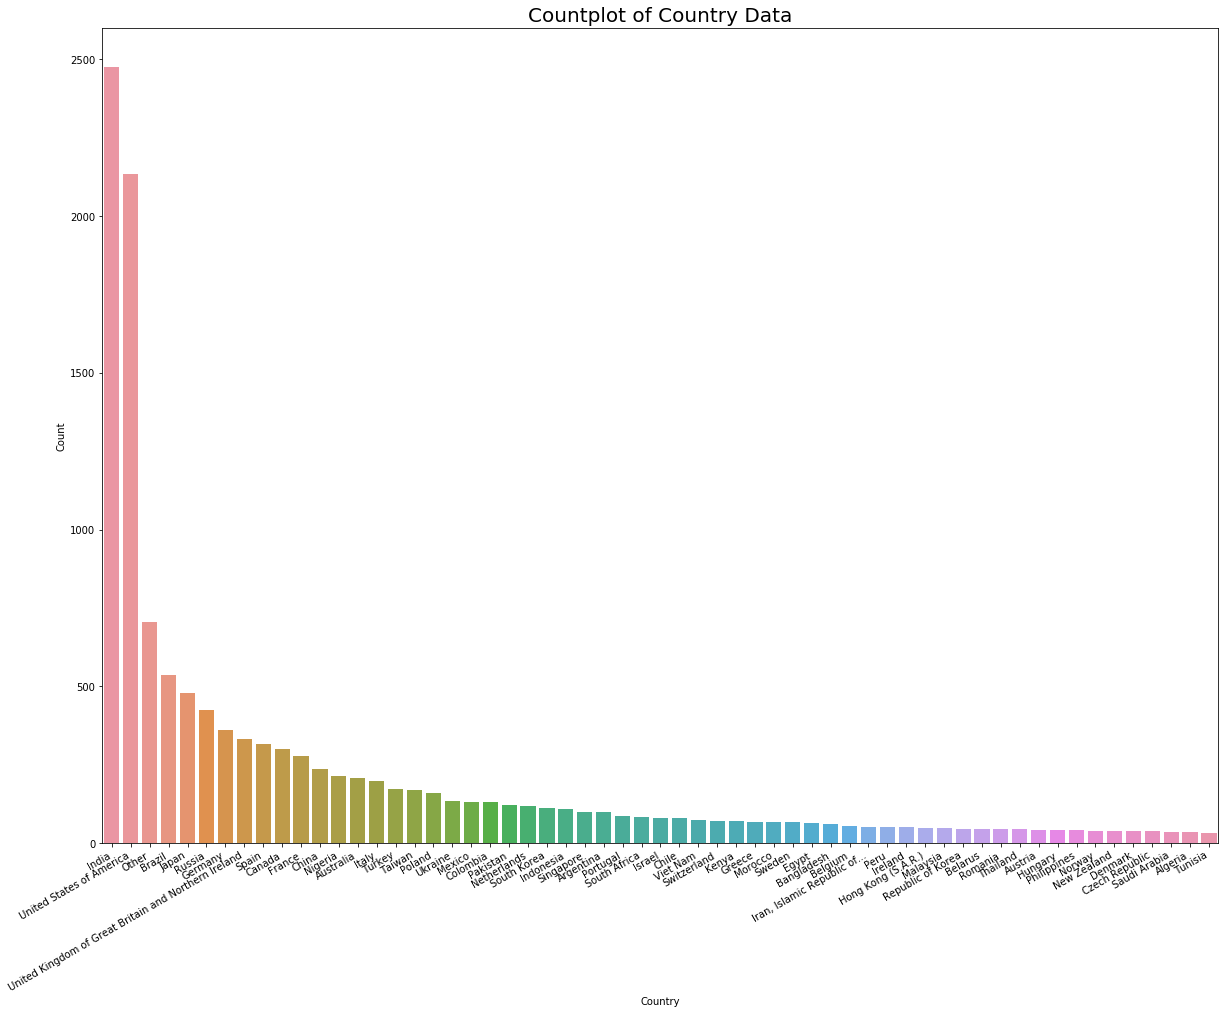

In [114]:
df = df[1:]

q2_map = {"Q2": {'Prefer to self-describe': 'Other', 'Prefer not to say': 'Other'}}
df = df.replace(q2_map)

print(df["Q2"].unique())

plt.figure(figsize=(20,15))
plt.title("Countplot of Country Data", fontsize=20)
country_plot = sb.countplot(df["Q3"], order=df["Q3"].value_counts().index)
country_plot.set_xticklabels(country_plot.get_xticklabels(), size=10 ,rotation=30, ha="right")
country_plot.set_xlabel("Country")
country_plot.set_ylabel("Count")
plt.show()

From the above plot we can see that the 9 most popular non-'Other' countries are India, USA, Brazil, Japan, Russia, Germany, United Kingdom of Great Britain and Northern Ireland, Spain, and Canada. These countries will each be given their own column while the other countries will be aggregated into the 'Other' column.

In [115]:
print(df["Q3"].describe())

top_countries = set(["India", "United States of America", "Brazil", "Japan", "Russia", "Germany", "United Kingdom of Great Britain and Northern Ireland", "Spain", "Canada"])

def reduce_countries(element):
    if element not in top_countries:
        return 'Other'
    return element

df["Q3"] = df["Q3"].map(reduce_countries)

# one-hot columns:
one_hot_columns = ["Q2", "Q3", "Q5", "Q8", "Q14", "Q19"]

# numerical columns:
numerical_columns = ["Q1", "Q4", "Q6", "Q7", "Q11", "Q15", "Q22", "Q23"]


for column in one_hot_columns:
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
    df.drop([column], axis=1, inplace=True)
df.head()

count     12497
unique       59
top       India
freq       2477
Name: Q3, dtype: object


,Time from Start to Finish (seconds),Q1,Q4,Q6,Q7,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,...,Q19_C++,Q19_Java,Q19_Javascript,Q19_MATLAB,Q19_None,Q19_Other,Q19_Python,Q19_R,Q19_SQL,Q19_TypeScript
1,510,22-24,Master’s degree,"1000-9,999 employees",0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,423,40-44,Professional degree,"> 10,000 employees",20+,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,391,40-44,Master’s degree,"> 10,000 employees",20+,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,392,22-24,Bachelor’s degree,0-49 employees,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,470,50-54,Master’s degree,0-49 employees,3-4,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [116]:
for column in numerical_columns:
    print(column)
    print(df[column].unique())

Q1
['22-24' '40-44' '50-54' '55-59' '30-34' '18-21' '35-39' '25-29' '45-49'
 '60-69' '70+']
Q4
['Master’s degree' 'Professional degree' 'Bachelor’s degree'
 'Doctoral degree'
 'Some college/university study without earning a bachelor’s degree'
 'I prefer not to answer' 'No formal education past high school']
Q6
['1000-9,999 employees' '> 10,000 employees' '0-49 employees'
 '50-249 employees' '250-999 employees']
Q7
['0' '20+' '3-4' '1-2' '5-9' '10-14' '15-19']
Q11
['$0 (USD)' '> $100,000 ($USD)' '$10,000-$99,999' '$100-$999'
 '$1000-$9,999' '$1-$99' nan]
Q15
['1-2 years' 'I have never written code' '< 1 years' '20+ years'
 '3-5 years' '5-10 years' '10-20 years' nan]
Q22
['Never' nan 'Once' '6-24 times' '2-5 times' '> 25 times']
Q23
['1-2 years' nan '2-3 years' '< 1 years' '10-15 years' '3-4 years'
 '4-5 years' '5-10 years' '20+ years']


In [117]:

q1_map = {"Q1": {'18-21': 0, '22-24': 1, '25-29': 2, '30-34': 3, '35-39': 4, '40-44': 5, '45-49': 6, '50-54': 7, '55-59': 8, '60-69': 9, '70+': 10}}
df = df.replace(q1_map)

q4_map = {"Q4": {"I prefer not to answer": 0, "No formal education past high school": 0, "Some college/university study without earning a bachelor’s degree": 1, "Professional degree": 2, "Bachelor’s degree": 3, "Master’s degree": 4, "Doctoral degree": 5}}
df = df.replace(q4_map)

q6_map = {"Q6": {"0-49 employees": 0, '50-249 employees': 1, '250-999 employees': 2, '1000-9,999 employees': 3, '> 10,000 employees': 4}}
df = df.replace(q6_map)

q7_map = {"Q7": {'0': 0, '1-2': 1, '3-4': 2, '5-9': 3, '10-14': 4, '15-19': 5, '20+': 6}}
df = df.replace(q7_map)

# For the mode of Q11
print(df["Q11"].describe(), "\n")
# nan's exist
q11_map = {"Q11": {'$0 (USD)': 0, '$1-$99': 1, '$100-$999': 2, '$1000-$9,999': 3, '$10,000-$99,999': 4, '> $100,000 ($USD)': 5}}
df = df.replace(q11_map)

# For the mode of Q15
print(df["Q15"].describe())
# nan's exist
q15_map = {"Q15": {'I have never written code': 0, '< 1 years': 1, '1-2 years': 2, '3-5 years': 3, '5-10 years': 4, '10-20 years': 5, '20+ years': 6}}
df = df.replace(q15_map)

# nan's exist
q22_map = {"Q22": {'Never': 0, 'Once': 1, '2-5 times': 2, '6-24 times': 3, '> 25 times': 4}}
df = df.replace(q22_map)

# nan's exist
q23_map = {"Q23": {'< 1 years': 0, '1-2 years': 1, '2-3 years': 2, '3-4 years': 3, '4-5 years': 4, '5-10 years': 5, '10-15 years': 6, '20+ years': 8}}
df = df.replace(q23_map)
df.head()




count        12250
unique           6
top       $0 (USD)
freq          4038
Name: Q11, dtype: object 

count         11422
unique            7
top       3-5 years
freq           2818
Name: Q15, dtype: object


,Time from Start to Finish (seconds),Q1,Q4,Q6,Q7,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,...,Q19_C++,Q19_Java,Q19_Javascript,Q19_MATLAB,Q19_None,Q19_Other,Q19_Python,Q19_R,Q19_SQL,Q19_TypeScript
1,510,1,4,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,423,5,2,4,6,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,391,5,4,4,6,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,392,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,470,7,4,0,2,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [118]:
print(df["Q11"].dropna().count())
print(df["Q15"].dropna().count())
print(df["Q22"].dropna().count())
print(df["Q23"].dropna().count())

12250
11422
10550
10541


By dropping all of the NaN values we lose about 1.7k survey results. This is too many results to sacrifice. We could choose to set all of the NaN values to the mode of the categorical data, however, give the sheer magnitude of the NaN values we would just be enforcing the mode and creating potentially statistically significant results based off of nothing. The columns that contain the most amount of NaN values are Q22 and Q23. We will drop these columns and replace the NaN values present in the other numerically encoded data with the modes of each column. 

In [119]:
df.drop(["Q22", "Q23"], axis=1, inplace=True)
numerical_columns.remove("Q22")
numerical_columns.remove("Q23")

# Replacing NaN values present in Q11 and Q15 with their respective modes:
df["Q11"] = df["Q11"].replace(np.nan, 0)
df["Q15"] = df["Q15"].replace(np.nan, 3)

df.head()

,Time from Start to Finish (seconds),Q1,Q4,Q6,Q7,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,...,Q19_C++,Q19_Java,Q19_Javascript,Q19_MATLAB,Q19_None,Q19_Other,Q19_Python,Q19_R,Q19_SQL,Q19_TypeScript
1,510,1,4,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,423,5,2,4,6,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,391,5,4,4,6,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,392,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,470,7,4,0,2,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


There are now no NaN values left in the dataset and our entire dataset is numerical with the exception of our target variable, Q10. Q10 has been numerically encoded and appended to the dataset as a new column called "Q10_Encoded". Given that sklearn uses an output variable that is numerically encoded, we will use "Q10_Encoded" as our output variable.

In [120]:
print("Unique Income Buckets = {}".format(df["Q10_Encoded"].unique()))
df.drop(["Q10", "Q10_buckets"], axis=1, inplace=True)


# df.to_csv(datasets + "parsed_dataset.csv")

df.head()

Unique Income Buckets = [ 3.  0. 14.  6.  1.  8.  7.  9. 11.  4.  2. 10. 12. 13.  5.]


,Time from Start to Finish (seconds),Q1,Q4,Q6,Q7,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,...,Q19_C++,Q19_Java,Q19_Javascript,Q19_MATLAB,Q19_None,Q19_Other,Q19_Python,Q19_R,Q19_SQL,Q19_TypeScript
1,510,1,4,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,423,5,2,4,6,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,391,5,4,4,6,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,392,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,470,7,4,0,2,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


Now that the dataset has no NaN values, the dependent variables are encoded properly, and the independent target variable is encoded properly, we can begin our analysis. Our parsed dataset has 12497 entries and 257 columns. Our original dataset had 12497 entries as well. We were able to take our original dataset that was contaminated with NaN values and messy encodings and transform it into a usable dataset with the same number of entires. While our column space grew from 248 to 257, a column explosion resulting from the one-hot encoding of every unique survey response and origin country was avoided. 

In [121]:
print("Shape of parsed df = {}".format(df.shape))

Shape of parsed df = (12497, 257)


We will now split our data up into input variables and output variables:

In [122]:
dfx = df.drop(["Q10_Encoded"], axis=1)
dfy = df["Q10_Encoded"]

print(dfx.shape)
print(dfy.shape)
print(df.shape)

(12497, 256)
(12497,)
(12497, 257)


## Feature Selection
Prior to implementing a model, it is a good idea to discuss and visualize the dependence of the various features on the dependent variable. We will visualize the relationships present within our data between both the categorical variables and the output variable and the numerical variables and the output variable. Since our output variable is categorical, scatter plots don't provide us with useful information. Further, the r-value, which is a measure of the correlation between numerical variables, is not relevant either.

We must make use of statistics that allow us to characterize the relationships of numerical-categorical variable pairs and categorical-categorical variable pairs. These statistics will be explained in detail below.

### Categorical Variable Pairs
We can use the Pearson's Chi-Squared test to perform a test for independence. We perform this test to compare two categorical variables from a single population to determine if there is significant association between the two variables. The null hypothesis for this test is that the two categorical variables are independent. Thus, the alternate hypothesis is that they are associated with each other. We use this test when the sampling method is simple random sampling, the variables in question are categorical, and the expected frequency count for each cell in the contingency table is at least 5. 

The first step is to compute the degrees of freedom. The degrees of freedom will later be used in conjunction with the chi-squared value to determine the p-value. 

$DF = (N_r - 1) \cdot (N_c - 1)$

$N_r$ is the number of levels for the first categorical variable and $N_c$ is the number of levels for the second categorical variable. After computing the degrees of freedom, the expected frequencies for every level of the first and second categorical variables must be computed:

$E_{r, c} = \frac{(n_r \cdot n_c)}{N}$

$n_r$ is the total number of $r$-th level sample observations of the first categorical variable and $n_c$ is the total number of $c$-th level sample observations of the second categorical variable. $N$ is the sample size. After these values are computed for all $r$ and $c$, the chi-squared statistic can be computed:

$\chi^2 = \sum_{r, c}\frac{(O_{r, c} - E_{r, c})^2}{E_{r, c}}$

The observed frequency at $r$ and $c$, $E_{r, c}$, is the total number of observations in which both $r$ and $c$ were observed simultaneously. After computing the chi-squared value we can use this value in conjunction with the number of degrees of freedom to determine the p-value. From the p-value we can then decide if we should reject or accept the null hypothesis. 

### Numerical-Categorical Variable Pairs
Typically, we use a one way ANalysis Of VAriance (ANOVA) to determine if the difference between the means of two or more groups is statistically significant. To do this, we compute the F-statistic. The F-statistic is the ratio of the variance of the between group means to the mean of the within group variances. If the variance between the samples is greater than the variance within the samples then the samples are not drawn from the same population. The null hypothesis for an ANOVA is that all of the population means are equal. The alternative hypothesis is that at least one of the means is different. We can use an ANOVA when the populations from which the samples were obtained are approximately normal, the samples are independent, and the variances of the populations are equal. To conduct an ANOVA, we must first determine the grand mean, $x_{GM}$, of the samples, the sum of squares total, $SS(T)$, the within group variation, $SS(W)$, and the between group variation, $SS(B)$:

$\overline{x}_{GM} = \sum_{i=1}^{N}\frac{x_i}{N}$

The grand mean is the mean of all of the elements from all of the samples mixed into one group.

$SS(T) = \sum_{i=1}^N(x_i - \overline{x}_{GM})^2$
$DF(T) = M \cdot N - 1$

The total variation is the variation of all of the samples in this collective group. The number of degrees of freedom for this calculation is equal to the number of samples, $M$, times the total number of elements in each sample, $N$, minus 1. I.e., $DF = M \cdot N - 1$. This is because if we knew the grand mean and we knew all of the data points except for 1 we could figure out the last one. 

$SS(W) = \sum_{i, c}(x_{i, c} - \overline{x}_c)^2$
$DF(W) = M \cdot (N - 1)$

The within group variation is the variation that exists within each sample. For each sample group, we have $N - 1$ degrees of freedom because if we know the means of each group and $N - 1$ of the elements in each group, we could determine the final element. If we have $M$ groups, we have $M \cdot (N - 1)$ degrees of freedom. The within group variation is calculated for each sample, $c$, and aggregated.

$SS(B) = \sum_{c} N_c \cdot (\overline{x}_c - \overline{x}_{GM})^2$
$DF(B) = M - 1$

The sum of squares between is the total variation due to the differences between the means. To compute this, we sum over all of the squared differences between the means of each sample and the grand mean $N_c$ times for each sample group, $c$. For this calculation, assuming we know the mean of means, we can calculate one of the sample means if we have the other two sample means. Thus, the number of degrees of freedom in this calculation is equal to $M - 1$. Given the above metrics, an interesting relationship occurs:

$SS(T) = SS(W) + SS(B)$

Thus, the total variation in the data can be described as the sum of the variation within each of these groups plus the sum of the variation between the groups. This is useful because it shows that we can split up the total variation of the samples into the variations between the groups and the variation within the groups. The degrees of freedom of the calculations of the variations also add up:

$DF(W) + DF(B) = M \cdot (N - 1) + (M - 1) = M \cdot N - M + M - 1 = M \cdot N - 1 = DF(T)$

Using the variations defined above, we can compute the F-statistic:

$F  = \frac{\frac{SS(B)}{DF(B)}}{\frac{SS(W)}{DF(W)}}$

If the numerator is greater than the denominator then the variation present in the data is due primarily to the variation between the groups. Thus, a large F-statistic indicates that the considered samples do not have the same mean. Conversely, an F-statistic less than 1 shows that the variation of the data is explained more so by the variation within each sample. Thus, it is more likely that the samples have the same mean. Using the F-statistic we can compute the p-value. From the p-value and our threshold value (typically 0.05), we can determine if the observed results are statistically significant. Note that the F table is dependent on both the degrees of freedom of the numerator ($DF(B)$) and the denominator ($DF(W)$). 

When comparing a numerical and categorical variable, we split the numerical variable up into the various categories delineated by the unique values of the categorical variable. Then, to determine if the numerical and categorical variable are dependent, we conduct an ANOVA.  


### Feature Importance Visualization
To analyze the statistics for each column we will start by constructing a column groups dictionary that creates a list of question parts/options corresponding to each question. We can use this dictionary to compute the statistics for the question groups. Unfortunately, since the SkLearn functions that compute various statistics about the categorical variables only accept categorical variables that are numerically encoded, we must reformat the one-hot encoded questions into numerically encoded columns. 

In [123]:
column_groups_dict = dict()

for i in range(dfx.shape[1]):
    if column_groups_dict.get(dfx.columns[i][:3]) is not None:
        column_groups_dict[dfx.columns[i][:3]].append(dfx.columns[i])
    else:
        column_groups_dict[dfx.columns[i][:3]] = [dfx.columns[i]]


select_multiple_groups = set(["Q9_", "Q12", "Q13", "Q16", "Q17", "Q18", "Q20", "Q21", "Q24", "Q25", "Q26", "Q27", "Q28", "Q29", "Q30", "Q31", "Q32", "Q33", "Q34"])


print("All categorical variables for Q9_:\n\n", column_groups_dict["Q9_"])

print("\n\nAll categorical variables for Q12_:\n\n", column_groups_dict["Q12"])


All categorical variables for Q9_:

 ['Q9_Part_1', 'Q9_Part_2', 'Q9_Part_3', 'Q9_Part_4', 'Q9_Part_5', 'Q9_Part_6', 'Q9_Part_7', 'Q9_Part_8']


All categorical variables for Q12_:

 ['Q12_Part_1', 'Q12_Part_2', 'Q12_Part_3', 'Q12_Part_4', 'Q12_Part_5', 'Q12_Part_6', 'Q12_Part_7', 'Q12_Part_8', 'Q12_Part_9', 'Q12_Part_10', 'Q12_Part_11', 'Q12_Part_12']


Now we can visualize all of the questions and the various question types:

In [124]:
print("Manually one-hot encoded columns:\n", one_hot_columns)
print("\nManually numerically encoded columns:\n", numerical_columns)
print("\nColumns that have the 'select all that apply' property:\n", list(select_multiple_groups))
print("\nAll questions remaining in the dataset:\n", column_groups_dict.keys())

print("\nIntersection between one-hot columns that are not 'select all' and one-hot columns that are 'select all':\n", len(set(one_hot_columns).intersection(set(select_multiple_groups))), "\n")

print("\nNumber of questions remaining in the dataset =", len(column_groups_dict.keys()))
print("Number of one-hot encoded questions =", len(one_hot_columns))
print("Number of numerically encoded questions =", len(numerical_columns))
print("Number of 'select all that apply' questions =", len(list(select_multiple_groups)))
print("Sum of question categories (not including time of survey column) =", sum([len(one_hot_columns), len(numerical_columns), len(list(select_multiple_groups))]))

Manually one-hot encoded columns:
 ['Q2', 'Q3', 'Q5', 'Q8', 'Q14', 'Q19']

Manually numerically encoded columns:
 ['Q1', 'Q4', 'Q6', 'Q7', 'Q11', 'Q15']

Columns that have the 'select all that apply' property:
 ['Q28', 'Q29', 'Q20', 'Q24', 'Q13', 'Q17', 'Q32', 'Q33', 'Q16', 'Q27', 'Q9_', 'Q30', 'Q25', 'Q26', 'Q21', 'Q34', 'Q12', 'Q18', 'Q31']

All questions remaining in the dataset:
 dict_keys(['Tim', 'Q1', 'Q4', 'Q6', 'Q7', 'Q9_', 'Q11', 'Q12', 'Q13', 'Q15', 'Q16', 'Q17', 'Q18', 'Q20', 'Q21', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q2_', 'Q3_', 'Q5_', 'Q8_', 'Q14', 'Q19'])

Intersection between one-hot columns that are not 'select all' and one-hot columns that are 'select all':
 0 


Number of questions remaining in the dataset = 32
Number of one-hot encoded questions = 6
Number of numerically encoded questions = 6
Number of 'select all that apply' questions = 19
Sum of question categories (not including time of survey column) = 31


For the multiple choice questions in which only one response was possible we can use a chi-squared test for independence to determine if a significant enough relationship exists. First we will define a function that can convert a set of one-hot columns into one ordinally encoded column:

In [125]:
def create_ordinal_encoding(df_one_hot_columns):
    return_df = np.zeros((df_one_hot_columns.shape[0], 1))
    for i in range(df_one_hot_columns.shape[1]):
        return_df = return_df + i * np.array(df_one_hot_columns.iloc[:, i]).reshape(-1, 1)
    return return_df

Now, we can compute the chi-squared value and the p-value for all of the questions devoid of the 'select all that apply' property:

In [126]:
one_hot_chi_squared_dict = dict()
for one_hot_column in one_hot_columns:
    if len(one_hot_column) == 2:
         one_hot_column = one_hot_column + "_"
    dfx_splice = dfx[column_groups_dict[one_hot_column]]
    ordinal_encoding = create_ordinal_encoding(dfx_splice)
    chi2, pval = sklearn.feature_selection.chi2(ordinal_encoding, dfy)
    one_hot_chi_squared_dict[one_hot_column] = [chi2, pval]

We can threshold the columns on the typical p-value threshold of 0.05:

In [127]:
remove_key_list = []
print("Removed questions:\n")
for (key, value) in one_hot_chi_squared_dict.items():
    if value[1] > 0.05:
        print("{}, P-Value = {}".format(key, value[1]))
        remove_key_list.append(key)


for element in remove_key_list:
    del one_hot_chi_squared_dict[element]

print("\nRemaining questions that are not independent of the output variable:\n")
for (key, value) in one_hot_chi_squared_dict.items():
    print(key)

for removed_question in remove_key_list:
    for removed_question_part in column_groups_dict[removed_question]:
        dfx.drop(removed_question_part, axis=1, inplace=True)

df.head()

Removed questions:

Q2_, P-Value = [0.40224756]

Remaining questions that are not independent of the output variable:

Q3_
Q5_
Q8_
Q14
Q19


,Time from Start to Finish (seconds),Q1,Q4,Q6,Q7,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,...,Q19_C++,Q19_Java,Q19_Javascript,Q19_MATLAB,Q19_None,Q19_Other,Q19_Python,Q19_R,Q19_SQL,Q19_TypeScript
1,510,1,4,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,423,5,2,4,6,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,391,5,4,4,6,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,392,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,470,7,4,0,2,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


We will now perform an ANOVA/F-test to determine if the ordinally encoded columns in the dataset are statistically independent of the output variable:

In [128]:
f_stat_numerical_dict = dict()

f_stats, p_stats = sklearn.feature_selection.f_classif(dfx[numerical_columns], dfy)

print("F-Statistics:", f_stats)
print("P-Values:", p_stats)

F-Statistics: [145.89996572  24.17625414  44.13706727  51.60818088 120.11461939
 189.35089532]
P-Values: [0.00000000e+000 8.75893571e-063 1.00528615e-119 6.79932185e-141
 0.00000000e+000 0.00000000e+000]


From the p-values above, we can see that all of the numerical features have unique means for the classes defined by dfy. Thus, we will not remove any columns from this dataset. All of these columns may aid our model's accuracy. 

The remaining columns are multiple-choice columns with the 'select all that apply' property. We will use the chi-squared test on all of these columns and we will remove the columns below the p-value threshold:

In [129]:
select_all_chi_squared_dict = dict()
for select_multiple_group in select_multiple_groups:
    dfx_splice = dfx[column_groups_dict[select_multiple_group]]
    ordinal_encoding = create_ordinal_encoding(dfx_splice)
    chi2, pval = sklearn.feature_selection.chi2(ordinal_encoding, dfy)
    select_all_chi_squared_dict[select_multiple_group] = [chi2, pval]

select_all_remove_key_list = []
print("Removed questions:\n")
for (key, value) in select_all_chi_squared_dict.items():
    if value[1] > 0.05:
        print("{}, P-Value = {}".format(key, value[1]))
        select_all_remove_key_list.append(key)


for element in select_all_remove_key_list:
    del select_all_chi_squared_dict[element]

print("\nRemaining questions that are not independent of the output variable:\n")
for (key, value) in select_all_chi_squared_dict.items():
    print(key)

for removed_question in select_all_remove_key_list:
    for removed_question_part in column_groups_dict[removed_question]:
        dfx.drop(removed_question_part, axis=1, inplace=True)

dfx.head()

Removed questions:


Remaining questions that are not independent of the output variable:

Q28
Q29
Q20
Q24
Q13
Q17
Q32
Q33
Q16
Q27
Q9_
Q30
Q25
Q26
Q21
Q34
Q12
Q18
Q31


,Time from Start to Finish (seconds),Q1,Q4,Q6,Q7,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,...,Q19_C++,Q19_Java,Q19_Javascript,Q19_MATLAB,Q19_None,Q19_Other,Q19_Python,Q19_R,Q19_SQL,Q19_TypeScript
1,510,1,4,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,423,5,2,4,6,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,391,5,4,4,6,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,392,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,470,7,4,0,2,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


No questions were removed as a result of this process. 

### Feature Selection Algorithm: Recursive Feature Selection
After computing the statistics associated with each question, we will now implement the feature selection algorithm recursive feature selection (RFE). RFE recursively removes attributes by identifying the attributes that contribute the most to predicting the target attribute. This algorithm is illustrated below (Note that this code has been commented out because it takes a long time to run):

In [130]:
# model = LogisticRegression(solver='lbfgs')
# rfe = sklearn.feature_selection.RFE(model, 150)
# fit = rfe.fit(dfx, dfy)
# print(fit.n_features_)
# print(fit.support_)
# print(fit.ranking_)

The algorithm selected the best 150 features for predicting on dfy and created a support_ mask that we can use to transform our original dataset into a more concise one. The most impactful columns are delineated below:

In [131]:
# print(dfx.columns[fit.support_][:75])
# print(dfx.columns[fit.support_][75:])

updated_columns = ['Q9_Part_8', 'Q11', 'Q12_Part_2', 'Q12_Part_11', 'Q13_Part_5',
       'Q13_Part_7', 'Q13_Part_11', 'Q13_Part_12', 'Q15', 'Q16_Part_5',
       'Q16_Part_9', 'Q16_Part_11', 'Q17_Part_2', 'Q17_Part_3', 'Q17_Part_4',
       'Q17_Part_5', 'Q17_Part_8', 'Q17_Part_10', 'Q17_Part_12', 'Q18_Part_5',
       'Q18_Part_10', 'Q18_Part_11', 'Q18_Part_12', 'Q20_Part_3', 'Q20_Part_4',
       'Q20_Part_7', 'Q20_Part_9', 'Q20_Part_10', 'Q20_Part_12', 'Q21_Part_1',
       'Q21_Part_3', 'Q21_Part_4', 'Q21_Part_5', 'Q24_Part_5', 'Q24_Part_7',
       'Q24_Part_8', 'Q24_Part_10', 'Q24_Part_11', 'Q24_Part_12', 'Q25_Part_2',
       'Q25_Part_3', 'Q25_Part_4', 'Q25_Part_7', 'Q25_Part_8', 'Q26_Part_1',
       'Q26_Part_2', 'Q26_Part_3', 'Q26_Part_4', 'Q26_Part_5', 'Q26_Part_6',
       'Q26_Part_7', 'Q27_Part_2', 'Q27_Part_3', 'Q27_Part_4', 'Q27_Part_5',
       'Q27_Part_6', 'Q28_Part_10', 'Q28_Part_12', 'Q29_Part_1', 'Q29_Part_2',
       'Q29_Part_3', 'Q29_Part_4', 'Q29_Part_5', 'Q29_Part_7', 'Q29_Part_9',
       'Q29_Part_12', 'Q30_Part_1', 'Q30_Part_2', 'Q30_Part_3', 'Q30_Part_4',
       'Q30_Part_5', 'Q30_Part_6', 'Q30_Part_7', 'Q30_Part_8', 'Q30_Part_9',
       'Q30_Part_10', 'Q30_Part_11', 'Q30_Part_12', 'Q31_Part_1', 'Q31_Part_2',
       'Q31_Part_4', 'Q31_Part_5', 'Q31_Part_6', 'Q31_Part_7', 'Q31_Part_8',
       'Q31_Part_9', 'Q31_Part_10', 'Q31_Part_12', 'Q32_Part_1', 'Q32_Part_2',
       'Q32_Part_3', 'Q32_Part_4', 'Q32_Part_5', 'Q32_Part_6', 'Q32_Part_8',
       'Q32_Part_9', 'Q32_Part_10', 'Q32_Part_12', 'Q33_Part_1', 'Q33_Part_2',
       'Q33_Part_3', 'Q33_Part_4', 'Q33_Part_5', 'Q33_Part_6', 'Q33_Part_7',
       'Q33_Part_8', 'Q33_Part_9', 'Q33_Part_10', 'Q33_Part_11', 'Q33_Part_12',
       'Q34_Part_1', 'Q34_Part_6', 'Q34_Part_7', 'Q34_Part_8', 'Q34_Part_9',
       'Q34_Part_10', 'Q34_Part_11', 'Q34_Part_12', 'Q3_Brazil', 'Q3_Canada',
       'Q3_Germany', 'Q3_India', 'Q3_Japan', 'Q3_Other', 'Q3_Russia',
       'Q3_Spain', 'Q3_United Kingdom of Great Britain and Northern Ireland',
       'Q3_United States of America', 'Q5_Business Analyst',
       'Q5_DBA/Database Engineer', 'Q5_Data Analyst', 'Q5_Data Engineer',
       'Q5_Other', 'Q5_Product/Project Manager', 'Q5_Research Scientist',
       'Q5_Statistician', 'Q8_I do not know',
       'Q8_No (we do not use ML methods)',
       'Q8_We are exploring ML methods (and may one day put a model into production)',
       'Q8_We recently started using ML methods (i.e., models in production for less than 2 years)',
       'Q8_We use ML methods for generating insights (but do not put working models into production)',
       'Q14_Basic statistical software (Microsoft Excel, Google Sheets, etc.)',
       'Q14_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)',
       'Q14_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)',
       'Q19_Bash', 'Q19_C', 'Q19_C++', 'Q19_Java', 'Q19_MATLAB', 'Q19_Other']

We could have used l1 regularization for feature selection. L1 (lasso) regularization is able to shrink the coefficients of the less important features to zero. However, after trying l1 regularization some features were removed that contributed to the success of the model. 

I determined that by keeping a significant number of features (150), the model was able to learn some of the more complex relationships present in the data. Originally, I tried 30 features, then 100, then 150, and finally 200. I found that using 30, 50, or 100 features resulted in a simple model that plateaued after using 10% of the training data. Using 200 features the model failed to generalize properly. 150 features seemed to be the soft spot between generalizability and complexity. 

### RFE Improvement Illustration
Using a logistic regression model and all of the columns from the dataset we achieve an accuracy of 75.42% when using the entire dataset to train the model and then test the model on the same data:

In [132]:
model = LogisticRegression(multi_class="auto", solver="liblinear")
model.fit(dfx, dfy)
predictions = model.predict(dfx)

TN = confusion_matrix(dfy, predictions)[0][0]
FP = confusion_matrix(dfy, predictions)[0][1]
FN = confusion_matrix(dfy, predictions)[1][0]
TP = confusion_matrix(dfy, predictions)[1][1]

total = TN + FP + FN + TP
ACC = (TP + TN) / float(total)

print ("This model got an accuracy of {}% on the entire dataset".format(round(ACC*100,2)))  

This model got an accuracy of 75.42% on the entire dataset


Using the features from the RFE algorithm we obtain an accuracy of 75.76%, which is higher:

In [133]:
dfx = dfx[updated_columns]

model = LogisticRegression(multi_class="auto", solver="liblinear")
model.fit(dfx, dfy)
predictions = model.predict(dfx)

TN = confusion_matrix(dfy, predictions)[0][0]
FP = confusion_matrix(dfy, predictions)[0][1]
FN = confusion_matrix(dfy, predictions)[1][0]
TP = confusion_matrix(dfy, predictions)[1][1]

total = TN + FP + FN + TP
ACC = (TP + TN) / float(total)

print ("This model got an accuracy of {}% on the entire dataset".format(round(ACC*100,2)))  

This model got an accuracy of 75.76% on the entire dataset


## Model Implementation
### Data Splitting
First, we will split our data into training and testing data. We will use 70% of our data for training and 30% of our data for testing:

In [134]:
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, random_state=88, test_size=0.3)

### 10-Fold Cross-Validation
To start off, we will create a logistic regression model and determine the accuracies of a basic model with an inverse regularization constant, C, of 1, using 10-fold cross-validation:

In [135]:
model = LogisticRegression(solver="liblinear", multi_class="auto")
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_train)

accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X_train):
    k_X_train, k_X_test = dfx.values[train_idx], dfx.values[test_idx]
    k_y_train, k_y_test = dfy.values[train_idx], dfy.values[test_idx]
    
    k_X_train = scaler.fit_transform(k_X_train.astype(float))
    k_X_test = scaler.transform(k_X_test.astype(float))
    
    model.fit(k_X_train, k_y_train)
    
    predictions = model.predict(k_X_test)
    
    TN = confusion_matrix(k_y_test, predictions)[0][0]
    FP = confusion_matrix(k_y_test, predictions)[0][1]
    FN = confusion_matrix(k_y_test, predictions)[1][0]
    TP = confusion_matrix(k_y_test, predictions)[1][1]
    total = TN + FP + FN + TP
    ACC = (TP + TN) / float(total)
    
    accuracy[np_idx] = ACC*100
    np_idx += 1
    
    print("Fold {}: Accuracy: {}%".format(np_idx, round(ACC*100,3)))   

print("Average Score: {}%".format(round(np.mean(accuracy), 3)))
print("Accuracy Standard Deviation: {}".format(round(np.std(accuracy), 3)))
print("Accuracy Variance: {}".format(round(np.square(np.std(accuracy)), 3)))

Fold 1: Accuracy: 68.276%
Fold 2: Accuracy: 75.641%
Fold 3: Accuracy: 76.163%
Fold 4: Accuracy: 74.251%
Fold 5: Accuracy: 73.18%
Fold 6: Accuracy: 75.0%
Fold 7: Accuracy: 73.09%
Fold 8: Accuracy: 76.727%
Fold 9: Accuracy: 75.253%
Fold 10: Accuracy: 73.765%
Average Score: 74.135%
Accuracy Standard Deviation: 2.271
Accuracy Variance: 5.158


From the above code snippet we can see that the average accuracy for the 10-fold cross-validation process defined above is 74.135% with a standard deviation of 2.271 and a variance of 5.158. Note that we can also use the ```predict_proba``` sklearn function to extract the probabilistic predictions for the dataset:

In [136]:
model = LogisticRegression(solver="liblinear", multi_class="auto")
model.fit(X_train, y_train)
predictions = model.predict_proba(X_train)

print("Shape of probabilistic predictions:", predictions.shape)
print("First 5 probabilistic predictions:", predictions[:5])

Shape of probabilistic predictions: (8747, 15)
First 5 probabilistic predictions: [[1.24818028e-01 2.10727785e-02 2.24803010e-02 2.41471912e-02
  4.60228967e-02 4.50333393e-02 7.05459556e-02 1.42948783e-01
  8.49920134e-02 3.79799734e-02 1.77542838e-01 7.78933264e-02
  4.00619605e-02 3.48917511e-02 4.95688641e-02]
 [4.34449777e-01 2.36804914e-02 3.51969712e-02 4.82106216e-02
  4.64329264e-02 7.62309008e-02 7.79498185e-02 5.30902118e-02
  9.15899126e-02 3.37533738e-02 4.26130594e-02 8.91987275e-03
  1.36871870e-02 6.03148736e-03 8.16338887e-03]
 [7.98332281e-01 8.32000698e-02 4.10621669e-02 2.08890168e-02
  2.42551359e-02 1.27173329e-02 9.25761993e-03 4.51082290e-03
  1.33056116e-03 2.07896740e-03 1.58412886e-03 5.37384174e-04
  5.91410145e-05 1.56292539e-05 1.69742262e-04]
 [3.72843438e-01 3.37456553e-01 1.07858990e-01 4.97123241e-02
  3.42943172e-02 3.24429444e-02 1.93952221e-02 7.09739882e-03
  4.29050388e-03 3.09532645e-03 2.15302106e-02 8.66745876e-03
  1.08161009e-03 1.24585858e-0

The ```predict_proba``` function will be useful in the immediate future because it will allow us to penalize the model when it is certain that it was right and it was wrong, and reward the model when the contrary is true. We may choose not to use it, however, depending on which accuracy metric we use to score the models. 


## Hyper-Parameter Tuning
We will now systematically determine which model we should select through a hyperparameter tuning process. The traditional accuracy metric in which you take the accuracy of your predictions with respect to the target variables is sometimes not very useful. This metric does not characterize the value of true positives, true negatives, false positives, and false negatives for the various classes. Depending on the context, taking these metrics into account may be more insightful. 

### Performance Metric Discussion
The consequences of TPs, TNs, FPs, and FNs are profound in certain contexts. The following discussion highlights some of the performance metric options that exist that we can use to evaluate our classification model: 

#### Accuracy

Measures the total accuracy of the generated model on some data. This metric can be misleading because it weights each correct prediction in the same way. If the data is skewed in a major way then a weak model can obtain very high accuracy.

$A = \frac{C}{T}$

$C$ is the number of correct predictions and $T$ is the total number of predictions made. 

#### Confusion Matrix
This performance visualization tool delineates the true postives, true, negatives, false positives, and false negatives for all of the predicted categorical values. This tool is valuable because it speaks to which classes the model is favoring. It also characterizes how well the model is predicting each class. The diagonal elements of the confusion matrix are the occurences where the predictions matched the target values. We can use the confusion matrix to generate other metrics such as precision.

#### Precision
The precision of a given class is *the number of times that class was correctly predicted divided by the total number of predictions for that particular class*:

$P = \frac{TP}{TP + FP}$

This metric is particularly valuable if we know the value of predicting various features. If predicting a certain column is particularly important we can compute the precision of our model on that column and assess our model in that way. Using the confusion matrix we can extract the total number of predictions for a given feature by summing along that prediction row. We can easily extract the number of accurate predictions for feature $i$ by considering the $i$-th column in the $i$-th row. 

*If we want to minimize the number of false positives for a given target bin we will want to maximize the precision of our model.*

#### Recall
The recall of a given class is *the number of times that class was correctly predicted divided by the total number of times that class was actually true*:

$R = \frac{TP}{TP + FN}$

We can obtain this metric by extracting the diagonal element associated with the $i$-th row in question and dividing by the sum along the $i$-th column. 

*If we want to minimize the number of false negatives for a given target we will want to maximize the recall of our model.*

#### F-Measure
The F-Measure combines precision and recall for a given feature into one metric. A model that has excellent precision and excellent recall will have an F-Measure that approaches 1. A model with weak precision or weak recall will have a resultant F-Measure that is closer to 0. To calculate the F-Measure of a feature we use the following formula:

$F = \frac{2 \cdot P \cdot R}{P + R}$

### Performance Metric Selection
Prior to selecting a metric from the ones outlined above, we should first consider the distribution of the target data:

In [137]:
dfy_one_hot = pd.get_dummies(dfy)
dfy_counts = []
for column in dfy_one_hot.columns:
    dfy_count = round(dfy_one_hot[column][dfy_one_hot[column] == 1].count()/dfy_one_hot.shape[0]*100, 3)
    dfy_counts.append(dfy_count)
    print("Column {} has {}% of the target values".format(column, dfy_count))

Column 0.0 has 32.328% of the target values
Column 1.0 has 10.899% of the target values
Column 2.0 has 8.066% of the target values
Column 3.0 has 5.825% of the target values
Column 4.0 has 5.753% of the target values
Column 5.0 has 5.633% of the target values
Column 6.0 has 4.609% of the target values
Column 7.0 has 4.193% of the target values
Column 8.0 has 3.241% of the target values
Column 9.0 has 3.017% of the target values
Column 10.0 has 6.001% of the target values
Column 11.0 has 3.865% of the target values
Column 12.0 has 3.473% of the target values
Column 13.0 has 1.32% of the target values
Column 14.0 has 1.776% of the target values


From the above, we can see that the 0th category contains most of the target values. This is illustrated by the following countplot:

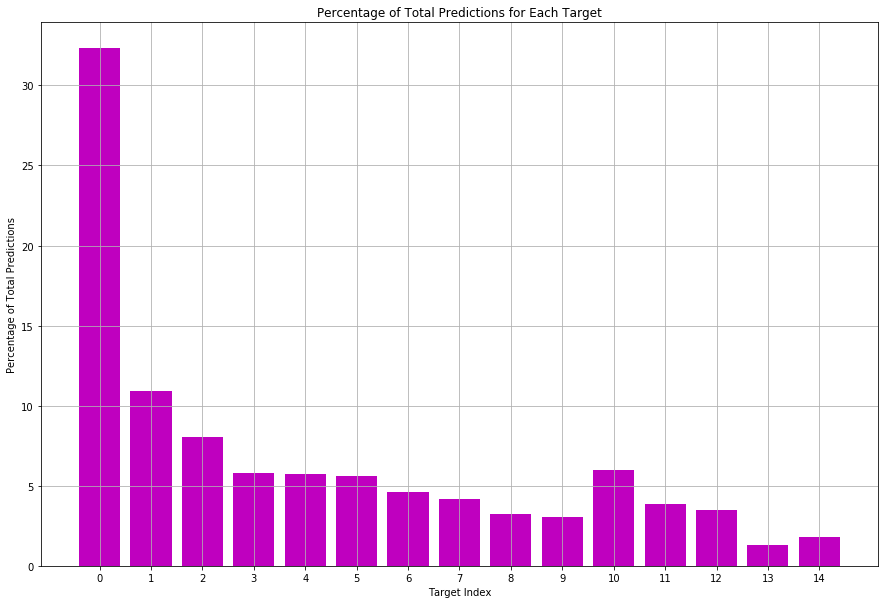

In [138]:
indices = np.arange(15)
plt.figure(figsize=(15, 10))
plt.bar(indices, dfy_counts, color="m")
plt.grid()
plt.xlabel("Target Index")
plt.xticks(indices)
plt.ylabel("Percentage of Total Predictions")
plt.title("Percentage of Total Predictions for Each Target")
plt.show()

Clearly, the targets that are data must predict are unbalanced. How we deal with this unbalanced dataset will determine the strengths and weaknesses of our model. 

In our context we are trying to create a model that is able to predict the salary bin of data scientists from all over the world. We can choose to have a model that prioritizes accuracy or a model that is more balanced that prioritizes recall and precision. Given that a data scientist's salary is more likely to fall into the first few bins (https://datasciencedegree.wisconsin.edu/data-science/data-scientist-salary/#:~:text=Despite%20a%20recent%20influx%20of,median%20salary%20rises%20to%20%24195%2C000.), we will select a model that prioritizes accuracy as opposed to F-score. 

Thus, we will consider the average accuracy of each model and the variance of those accuracies using 10-fold cross-validation. We will also use the F-score of each model to characterize precision and recall. The model that minimizes the variance between the accuracies and minimizes the bias (thus, maximizing the average accuracy) will be chosen. 

All of the results are compiled into a model results dictionary and they are displayed after each 10-fold cross-validation is complete. Grid-search was conducted using several different regularization constants, all of the possible solvers obtained from the SkLearn logistic regression documentation, l1 & l2 regularization, and balanced versus None class weights. Scaling of the features was implemented because linear models benefit from feature scaling. The results were compiled into a model results dictionary and displayed below:

In [139]:
# scaler = StandardScaler()
# kfold = KFold(n_splits=10)
# kfold.get_n_splits(X_train)

# best_model = None
# best_params = {}
# best_accuracy = 0
# best_std = 0

# model_results_dict = dict()
# model_index = 0

# for C in [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 1, 5, 10, 100]:
#     for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
#         for regularization_type in ["l1", "l2"]:
#             for c_weight in [None, "balanced"]:
#                 if  regularization_type == "l1" and solver in set(['newton-cg', 'sag', 'lbfgs']):
#                     continue
                
#                 scaler = StandardScaler()
#                 model = LogisticRegression(C=C, solver=solver, penalty=regularization_type, class_weight=c_weight)
                
#                 accuracy = np.zeros(10)
#                 log_losses = np.zeros(10)
#                 f1_micros = np.zeros(10)
#                 f1_macros = np.zeros(10)

#                 np_idx = 0
                
#                 for train_idx, test_idx in kfold.split(X_train):
#                     k_X_train, k_X_test = X_train.values[train_idx], X_train.values[test_idx]
#                     k_y_train, k_y_test = y_train.values[train_idx], y_train.values[test_idx]

#                     k_X_train = scaler.fit_transform(k_X_train)
#                     k_X_test = scaler.transform(k_X_test)

#                     scaler.fit_transform(k_X_train)
#                     model.fit(scaler.transform(k_X_train), k_y_train)

#                     probabilistic_predictions = model.predict_proba(k_X_test)
#                     predictions = model.predict(k_X_test)

#                     TN = confusion_matrix(k_y_test, predictions)[0][0]
#                     FP = confusion_matrix(k_y_test, predictions)[0][1]
#                     FN = confusion_matrix(k_y_test, predictions)[1][0]
#                     TP = confusion_matrix(k_y_test, predictions)[1][1]
#                     total = TN + FP + FN + TP


#                     # Performance Metrics:
#                     log_loss = sklearn.metrics.log_loss(k_y_test, probabilistic_predictions, normalize=True)
#                     f1_micro = sklearn.metrics.f1_score(k_y_test, predictions, average="micro")
#                     f1_macro = sklearn.metrics.f1_score(k_y_test, predictions, average="macro")

#                     log_losses[np_idx] = log_loss
#                     f1_micros[np_idx] = f1_micro
#                     f1_macros[np_idx] = f1_macro

#                     ACC = (TP + TN) / float(total)

#                     accuracy[np_idx] = ACC*100

#                     np_idx += 1

                    
                
#                 average_accuracy = round(np.mean(accuracy), 3)
#                 accuracy_std_dev = round(np.std(accuracy), 3)
#                 accuracy_variance = round(np.square(accuracy_std_dev), 3)
                
#                 average_log_loss = round(np.mean(log_losses), 3)
#                 average_f1_micro = round(np.mean(f1_micros), 3)
#                 average_f1_macro = round(np.mean(f1_macros), 3)

#                 model_results_dict[model_index] = {"log-loss": average_log_loss, "f1-micro": average_f1_micro, "f1-macro": average_f1_macro, "accuracy": average_accuracy, "variance": accuracy_variance, "C": C, "solver": solver, "class-weight": c_weight, "penalty": regularization_type}
#                 model_index += 1

#                 print("\nC = {}, Solver = {}, Class-Weight = {}, Penalty = {}".format(C, solver, c_weight, regularization_type))
#                 print("Average Accuracy: {}%".format(average_accuracy))
#                 print("Average Log Loss: {}".format(average_log_loss))
#                 print("Average F1-Micro: {}".format(average_f1_micro))
#                 print("Average F1-Macro: {}".format(average_f1_macro))
#                 print("Accuracy Standard Deviation: {}".format(accuracy_std_dev))
#                 print("Accuracy Variance: {}".format(accuracy_variance))



#                 if np.mean(accuracy) > best_accuracy:
#                     best_accuracy = np.mean(accuracy)
#                     best_model = model_results_dict[model_index-1]
# print("\n\n", best_model)

In [140]:
best_model = {'log-loss': 2.493, 'f1-micro': 0.327, 'f1-macro': 0.13, 'accuracy': 75.841, 'variance': 2.582, 'C': 0.001, 'solver': 'liblinear', 'class-weight': 'balanced', 'penalty': 'l2'}

# alternatives:
# C = 0.001, Solver = newton-cg, Class-Weight = None, Penalty = l2
# Average Accuracy: 74.883%
# Average Log Loss: 2.081
# Average F1-Micro: 0.344
# Average F1-Macro: 0.074
# Accuracy Standard Deviation: 1.469
# Accuracy Variance: 2.158

# C = 0.001, Solver = lbfgs, Class-Weight = None, Penalty = l2
# Average Accuracy: 74.883%
# Average Log Loss: 2.081
# Average F1-Micro: 0.344
# Average F1-Macro: 0.074
# Accuracy Standard Deviation: 1.469
# Accuracy Variance: 2.158

# C = 0.001, Solver = sag, Class-Weight = None, Penalty = l2
# Average Accuracy: 74.883%
# Average Log Loss: 2.081
# Average F1-Micro: 0.344
# Average F1-Macro: 0.074
# Accuracy Standard Deviation: 1.469
# Accuracy Variance: 2.158

# C = 0.001, Solver = saga, Class-Weight = None, Penalty = l2
# Average Accuracy: 74.883%
# Average Log Loss: 2.081
# Average F1-Micro: 0.344
# Average F1-Macro: 0.074
# Accuracy Standard Deviation: 1.469
# Accuracy Variance: 2.158

# C = 0.01, Solver = liblinear, Class-Weight = balanced, Penalty = l1
# Average Accuracy: 75.65%
# Average Log Loss: 2.355
# Average F1-Micro: 0.333
# Average F1-Macro: 0.103
# Accuracy Standard Deviation: 1.287
# Accuracy Variance: 1.656

# C = 0.01, Solver = saga, Class-Weight = None, Penalty = l1
# Average Accuracy: 74.551%
# Average Log Loss: 2.078
# Average F1-Micro: 0.343
# Average F1-Macro: 0.074
# Accuracy Standard Deviation: 1.41
# Accuracy Variance: 1.988

# C = 0.05, Solver = liblinear, Class-Weight = None, Penalty = l2
# Average Accuracy: 75.102%
# Average Log Loss: 2.068
# Average F1-Micro: 0.353
# Average F1-Macro: 0.132
# Accuracy Standard Deviation: 1.405
# Accuracy Variance: 1.974

# C = 0.05, Solver = saga, Class-Weight = None, Penalty = l1
# Average Accuracy: 75.216%
# Average Log Loss: 1.987
# Average F1-Micro: 0.359
# Average F1-Macro: 0.12
# Accuracy Standard Deviation: 1.377
# Accuracy Variance: 1.896

### Model Selection Discussion
The model that our grid search algorithm recommended has an average accuracy of 75.841% and a variance between the 10-fold cross-validation implementations of 2.582. This model uses a C value of 0.001, a liblinear solver, a balanced class-weight setting, and has an l2 regularization penalty. 

This model was selected by our algorithm because it minimized the bias metric and maximized average accuracy of the model on the training set through 10-fold cross-validation. Bias, however, isn't the only metric that we should consider when selecting a model. We should also consider variance. Variance speaks to how well the model can generalize. We want to select the model that minimizes bias and variance the best.

The alternate models that had comparable accuracy but less bias are included above. From these models we reason that the model with a C of 0.01, a liblinear solver, a balanced class-weight setting, and an l1 penalty does better than our recommended optimal model because it has a similar average accuracy of 75.65% but a variance of 1.656, which is much lower than the 2.582 variance returned by our optimal model. Thus, this is the model that we will select for testing.



In [141]:
# C = 0.01, Solver = liblinear, Class-Weight = balanced, Penalty = l1
# Average Accuracy: 75.65%
# Average Log Loss: 2.355
# Average F1-Micro: 0.333
# Average F1-Macro: 0.103
# Accuracy Standard Deviation: 1.287
# Accuracy Variance: 1.656
best_model = {'log-loss': 2.355, 'f1-micro': 0.103, 'f1-macro': 0.103, 'accuracy': 75.65, 'variance': 1.656, 'C': 0.01, 'solver': 'liblinear', 'class-weight': 'balanced', 'penalty': 'l1'}
for (key, value) in best_model.items():
    print("{}: {}".format(key, value))

log-loss: 2.355
f1-micro: 0.103
f1-macro: 0.103
accuracy: 75.65
variance: 1.656
C: 0.01
solver: liblinear
class-weight: balanced
penalty: l1



## Testing Our Optimal Model
### Model Testing
The code snippet below trains the optimal model using the training dataset. Then, it tests the model using the training dataset and the testing dataset. 

In [143]:
print(best_model)
scaler = StandardScaler()
model = LogisticRegression(C=1, solver=best_model["solver"], penalty=best_model["penalty"], class_weight=best_model["class-weight"], multi_class="auto")

scaler.fit_transform(X_train.astype(float))
model.fit(scaler.transform(X_train.astype(float)), y_train)

predictions = model.predict(scaler.transform(X_train.astype(float)))

TN = confusion_matrix(y_train, predictions)[0][0]
FP = confusion_matrix(y_train, predictions)[0][1]
FN = confusion_matrix(y_train, predictions)[1][0]
TP = confusion_matrix(y_train, predictions)[1][1]
total = TN + FP + FN + TP

ACC = (TP + TN) / float(total)

print("Training Accuracy = {}%".format(round(ACC*100, 3)))

scaler.fit_transform(X_test.astype(float))
predictions = model.predict(scaler.transform(X_test.astype(float)))

TN = confusion_matrix(y_test, predictions)[0][0]
FP = confusion_matrix(y_test, predictions)[0][1]
FN = confusion_matrix(y_test, predictions)[1][0]
TP = confusion_matrix(y_test, predictions)[1][1]
total = TN + FP + FN + TP

ACC = (TP + TN) / float(total)

print("Testing Accuracy = {}%".format(round(ACC*100, 3)))


{'log-loss': 2.355, 'f1-micro': 0.103, 'f1-macro': 0.103, 'accuracy': 75.65, 'variance': 1.656, 'C': 0.01, 'solver': 'liblinear', 'class-weight': 'balanced', 'penalty': 'l1'}
Training Accuracy = 75.418%
Testing Accuracy = 71.3%


We can see from the above snippet that we obtained a training accuracy of 75.418% and a testing accuracy of 71.3%. Since we trained our model using the training data, we expect our training accuracy to be much higher than the accuracy obtained when predicting on the holdout testing dataset. To investigate more into the generalizability of our model, we will investigate the bias-variance trade-off in the next section.

### Bias-Variance Tradeoff
Now that we have selected a model and tested this model on the testing dataset, I will determine and then comment on whether my model is overfitting or underfitting. To do this, I will train the model using different fractions of the training dataset. For each fraction I will record the training accuracy using the entire training dataset. I will also record the testing accuracy using the entire testing dataset. Then, I will plot both the training and testing accuracies as a function of the data fraction used to train that model.

In [144]:
training_accuracies = []
testing_accuracies = []
training_dataset_fractions = [x/100 for x in range(5, 101, 5)]
for training_dataset_fraction in training_dataset_fractions:
    fraction_length = round(training_dataset_fraction*X_train.shape[0])
    X_train_fraction = X_train[:fraction_length]
    y_train_fraction = y_train[:fraction_length]

    scaler = StandardScaler()
    model = LogisticRegression(C=1, solver=best_model["solver"], penalty=best_model["penalty"], class_weight=best_model["class-weight"], multi_class="auto")

    scaler.fit_transform(X_train_fraction.astype(float))
    model.fit(scaler.transform(X_train_fraction.astype(float)), y_train_fraction)
    predictions = model.predict(scaler.transform(X_train.astype(float)))


    TN = confusion_matrix(y_train, predictions)[0][0]
    FP = confusion_matrix(y_train, predictions)[0][1]
    FN = confusion_matrix(y_train, predictions)[1][0]
    TP = confusion_matrix(y_train, predictions)[1][1]
    total = TN + FP + FN + TP   

    training_acc = round((TP + TN) / float(total) * 100, 3)

    print("Training Accuracy = {}%".format(training_acc))

    training_accuracies.append(training_acc)

    scaler.fit_transform(X_test.astype(float))
    predictions = model.predict(scaler.transform(X_test.astype(float)))

    TN = confusion_matrix(y_test, predictions)[0][0]
    FP = confusion_matrix(y_test, predictions)[0][1]
    FN = confusion_matrix(y_test, predictions)[1][0]
    TP = confusion_matrix(y_test, predictions)[1][1]
    total = TN + FP + FN + TP


    testing_acc = round((TP + TN) / float(total) * 100, 3)
    print("Testing Accuracy = {}%\n".format(testing_acc))

    testing_accuracies.append(testing_acc)
print(model.get_params)     


Training Accuracy = 70.419%
Testing Accuracy = 68.545%

Training Accuracy = 74.67%
Testing Accuracy = 71.847%

Training Accuracy = 74.538%
Testing Accuracy = 71.145%

Training Accuracy = 74.677%
Testing Accuracy = 72.893%

Training Accuracy = 73.964%
Testing Accuracy = 71.684%

Training Accuracy = 75.147%
Testing Accuracy = 72.008%

Training Accuracy = 74.794%
Testing Accuracy = 72.396%

Training Accuracy = 74.86%
Testing Accuracy = 72.553%

Training Accuracy = 75.897%
Testing Accuracy = 72.799%

Training Accuracy = 75.805%
Testing Accuracy = 72.989%

Training Accuracy = 75.913%
Testing Accuracy = 72.789%

Training Accuracy = 75.539%
Testing Accuracy = 72.524%

Training Accuracy = 75.384%
Testing Accuracy = 73.084%

Training Accuracy = 75.435%
Testing Accuracy = 72.433%

Training Accuracy = 75.931%
Testing Accuracy = 72.46%

Training Accuracy = 75.374%
Testing Accuracy = 73.088%

Training Accuracy = 75.377%
Testing Accuracy = 72.493%

Training Accuracy = 75.248%
Testing Accuracy = 71.8

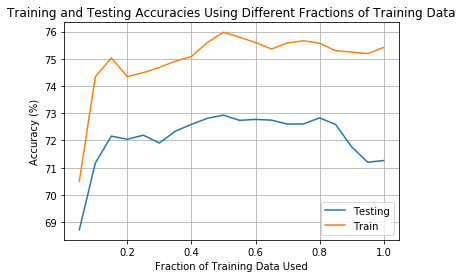

In [145]:
import scipy.signal
def plot_train_test_curve(iterations, train_acc, testing_acc):
    plt.title("Training and Testing Accuracies Using Different Fractions of Training Data")
    plt.plot(iterations, scipy.signal.savgol_filter(np.array(testing_acc), polyorder=3, window_length=5),
             label="Testing")
    plt.plot(iterations, scipy.signal.savgol_filter(np.array(train_acc), polyorder=3, window_length=5),
             label="Train")
    plt.xlabel("Fraction of Training Data Used")
    # plt.xticks(iterations)
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    return

plot_train_test_curve(training_dataset_fractions, training_accuracies, testing_accuracies)

From the plot above we can see that our model is overfitting on the training dataset. The pseudo-validation accuracy computed using the testing dataset peaked when 50% of the dataset was used. After that point, the testing accuracy began slowly declining as the variance of the model increased and the generalizability of the model decreased. A potential solution for this would be to implement early stopping or to choose a model with a more intense regularization constant. 

### Discussion
The implemented model fared well. I found through this process that generally, models that had less features (30, 50, etc.) performed significantly worse. This could be because these models missed out on some of the more intricate relationships present in the data. Having said this, perhaps a model with a few less features, i.e. a model with 120 features, would have been able to generalize to the testing dataset better. 

The implemented model has been optimized for general accuracy. Learning more about how the model might be used would incentivize a more fine-tuned performance metric. Moreover, this model utilized logistic regression. It could be the case that the relationships between the input data and the target variables are non-linear or more complex. Perhaps a more sophisticated or learned model would have achieved a stronger test accuracy. 